In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

## 9.
### a.
_문제: (10장에서 소개한) 패션 MNIST 데이터셋을 적재하고 훈련 세트, 검증 세트, 테스트
세트로 나눕니다. 훈련 세트를 섞은 다음 각 데이터셋을 TFRecord 파일로 저장합니
다. 각 레코드는 두 개의 특성을 가진 `Example` 프로토콜 버퍼, 즉 직렬화된 이미지(`tf.io.serialize_tensor()`를 사용해 이미지를 직렬화하세요)와 레이블입니다. 참고: 용량이 큰 이미지일 경우 `tf.io.encode_jpeg()`를 사용할 수 있습니다. 많은 공간을 절약할 수 있지만 이미지 품질이 손해를 봅니다._

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [3]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [5]:
valid_set.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>

아니 ㅅㅂ 왜 되는데 TFRecord 안되서 다른 걸로 시도해도 no feature ㅇㅈㄹ 했는데 갑자기 됨. ㅅㅂ?

오류 내용 :

NameError: name 'Example' is not defined

ValueError: Protocol message Feature has no "feature" field.


In [6]:
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

# 반드시 이렇게 임포트 해줘야 하는 듯 ?

def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    #image_data = tf.io.encode_jpeg(image[..., np.newaxis])
    ex_contents = Example(
                features=Features(
                    feature={
                        "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                        "label": Feature(int64_list=Int64List(value=[label])),
                    }))
    return ex_contents

In [7]:
# def create_example_fixed(image, label):
#     image_data = tf.io.serialize_tensor(image)
#     #image_data = tf.io.encode_jpeg(image[..., np.newaxis])
#     output = tf.train.Example(
#         features=tf.train.Feature(
#             feature={
#                 "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_data.numpy()])),
#                 "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label])),
#             }))
    
#     return output 

In [8]:
# for image, label in valid_set.take(1):
#     print(create_example_fixed(image, label))

In [9]:
for image, label in valid_set.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\000\000\000\000\000\000\000\000\001\000E\317\337\332\330\330\243\177yz\222\215X\254B\000\000\00

---


다음 함수는 주어진 데이터셋을 일련의 TFRecord 파일로 저장합니다. 이 예제는 라운드-로빈 방식으로 파일에 저장합니다. 이를 위해 `dataset.enumerate()` 메서드로 모든 샘플을 순회하고 저장할 파일을 겨정하기 위해 `index % n_shards`를 계산합니다. 표준 `contextlib.ExitStack` 클래스를 사용해 쓰는 동안 I/O 에러의 발생 여부에 상관없이 모든 `writer`가 적절히 종료되었는지 확인합니다.

In [10]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [11]:
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

### b.
_문제: tf.data로 각 세트를 위한 효율적인 데이터셋을 만듭니다. 마지막으로 이 데이터셋으로
입력 특성을 표준화하는 전처리 층을 포함한 케라스 모델을 훈련합니다. 텐서보드로 프로파일 데이터를 시각화하여 가능한 한 입력 파이프라인을 효율적으로 만들어보세요._

In [12]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)    # 위에서 정의한 대로 파싱
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)         # tensor로 변환
    #image = tf.io.decode_jpeg(example["image"])
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]

def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                  n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,    # 병렬로 읽을 파일 수 : num_parallel_reads
                                      num_parallel_reads=n_read_threads) 
    if cache:
        dataset = dataset.cache() # 각 에포크 동안 실행되는 일부 작업 저장 ?
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [13]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)

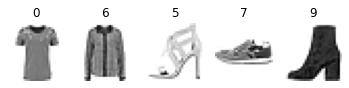

In [14]:
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

class Standardization(keras.layers.Layer):     # -> 입력특성 표준화  
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())
# 각 특성의 평균을 빼고 표준편차로 나눔. 0으로 나누는 것을 방지하기 위해 작은 수를 더함. 


standardization = Standardization(input_shape=[28, 28])
# or perhaps soon:
#standardization = keras.layers.Normalization()


sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                               axis=0).astype(np.float32)
standardization.adapt(sample_images)    # standardization 층을 모델에 추가하기 전에 
                                        # 데이터 샘플과 함께 adapt()호출

model = keras.models.Sequential([
    standardization,
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [16]:
from datetime import datetime
logs = os.path.join(os.curdir, "my_logs",   # my_logs 파일에 실시간으로 데이터를 만들고 담음
                    "run_" + datetime.now().strftime("%Y%m%d_%H%M%S"))

tensorboard_cb = tf.keras.callbacks.TensorBoard(            # 텐서보드 출력을 위한 데이터 콜백
    log_dir=logs, histogram_freq=1, profile_batch=10)

model.fit(train_set, epochs=5, validation_data=valid_set,
          callbacks=[tensorboard_cb])

Epoch 1/5
1719/1719 [==============================] - 21s 11ms/step - loss: 570.1453 - accuracy: 0.8415 - val_loss: 149.1328 - val_accuracy: 0.8670
Epoch 2/5
1719/1719 [==============================] - 16s 9ms/step - loss: 639.2181 - accuracy: 0.8785 - val_loss: 282.7338 - val_accuracy: 0.8730
Epoch 3/5
1719/1719 [==============================] - 15s 9ms/step - loss: 98.2001 - accuracy: 0.8905 - val_loss: 0.3451 - val_accuracy: 0.8790
Epoch 4/5
1719/1719 [==============================] - 19s 11ms/step - loss: 437.1323 - accuracy: 0.9012 - val_loss: 152.0194 - val_accuracy: 0.8812
Epoch 5/5
1719/1719 [==============================] - 16s 10ms/step - loss: 198.3816 - accuracy: 0.9077 - val_loss: 88.0071 - val_accuracy: 0.8796


In [17]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 11284), started 5 days, 2:11:58 ago. (Use '!kill 11284' to kill it.)

## 10.
_문제: 이 연습문제에서 데이터셋을 다운로드 및 분할하고 `tf.data.Dataset` 객체를 만들어 데이터를 적재하고 효율적으로 전처리하겠습니다. 그다음 `Embedding` 층을 포함한 이진 분류 모델을 만들고 훈련시킵니다._

### a.
_문제: [인터넷 영화 데이터베이스](https://imdb.com/)의 영화 리뷰 50,000개를 담은 [영화 리뷰
데이터셋](https://homl.info/imdb)을 다운로드합니다. 이 데이터는
`train`과 `test`라는 두 개의 디렉터리로 구성되어 있습니다. 각 디렉터리에는 12,500개의 긍정 리뷰를 담은 `pos` 서브디렉터리와 12,500개의 부정 리뷰를 담은 `neg` 서브디렉터리가 있습니다. 리뷰는 각각 별도의 텍스트 파일에 저장되어 있습니다. (전처리된 BOW를 포함해) 다른 파일과 디렉터리가 있지만 이 연습문제에서는 무시합니다._

In [19]:
from pathlib import Path

DOWNLOAD_ROOT = "http://ai.stanford.edu/~amaas/data/sentiment/"
FILENAME = "aclImdb_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, extract=True)
path = Path(filepath).parent / "aclImdb"
path

WindowsPath('C:/Users/NICE/.keras/datasets/aclImdb')

In [20]:
for name, subdirs, files in os.walk(path):
    indent = len(Path(name).parts) - len(path.parts)
    print("    " * indent + Path(name).parts[-1] + os.sep)
    for index, filename in enumerate(sorted(files)):
        if index == 3:
            print("    " * (indent + 1) + "...")
            break
        print("    " * (indent + 1) + filename)

aclImdb\
    README
    imdb.vocab
    imdbEr.txt
    test\
        labeledBow.feat
        urls_neg.txt
        urls_pos.txt
        neg\
            0_2.txt
            10000_4.txt
            10001_1.txt
            ...
        pos\
            0_10.txt
            10000_7.txt
            10001_9.txt
            ...
    train\
        labeledBow.feat
        unsupBow.feat
        urls_neg.txt
        ...
        neg\
            0_3.txt
            10000_4.txt
            10001_4.txt
            ...
        pos\
            0_9.txt
            10000_8.txt
            10001_10.txt
            ...
        unsup\
            0_0.txt
            10000_0.txt
            10001_0.txt
            ...


In [21]:
def review_paths(dirpath):
    return [str(path) for path in dirpath.glob("*.txt")]

train_pos = review_paths(path / "train" / "pos")
train_neg = review_paths(path / "train" / "neg")
test_valid_pos = review_paths(path / "test" / "pos")
test_valid_neg = review_paths(path / "test" / "neg")

len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)

(12500, 12500, 12500, 12500)

### b.
_문제: 테스트 세트를 검증 세트(15,000개)와 테스트 세트(10,000개)로 나눕니다._

In [22]:
np.random.shuffle(test_valid_pos)

test_pos = test_valid_pos[:5000]  # 5000개
test_neg = test_valid_neg[:5000]  # 5000개
valid_pos = test_valid_pos[5000:] # 7500개
valid_neg = test_valid_neg[5000:] # 7500개

### c.
_문제: tf.data를 사용해 각 세트에 대한 효율적인 데이터셋을 만듭니다._

이 데이터셋을 메모리에 적재할 수 있으므로 파이썬 코드와 `tf.data.Dataset.from_tensor_slices()`를 사용해 모든 데이터를 적재합니다:

In [23]:
def imdb_dataset(filepaths_positive, filepaths_negative):
    reviews = []
    labels = []
    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)): 
        # 1번째 부정 리뷰 반복, 2번째 긍정 리뷰 반복
        for filepath in filepaths:  
            with open(filepath) as review_file:
                reviews.append(review_file.read())
            labels.append(label)
    return tf.data.Dataset.from_tensor_slices(      # 각 요소마다 reviews와 labels 리스트 존재
        (tf.constant(reviews), tf.constant(labels)))    

In [61]:
for X, y in imdb_dataset(train_pos, train_neg).take(3):
    print(X)
    print(y)
    print()

tf.Tensor(b'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int32)

tf.Tensor(b'Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan t

In [62]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

44.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


이 데이터셋을 적재하고 10회 반복하는데 약 17초가 걸립니다.

하지만 이 데이터셋이 메모리에 맞지 않는다고 가정하고 좀 더 재미있는 것을 만들어 보죠. 다행히 각 리뷰는 한 줄로 되어 있기 때문에(`<br />`로 줄바꿈됩니다) `TextLineDataset`를 사용해 리뷰를 읽을 수 있습니다. 그렇지 않으면 입력 파일을 전처리해야 합니다(예를 들어, TFRecord로 바꿉니다). 매우 큰 데이터셋의 경우 아파치 빔(Apache Beam) 같은 도구를 사용하는 것이 합리적입니다.

In [63]:
def imdb_dataset(filepaths_positive, filepaths_negative, n_read_threads=5):
    dataset_neg = tf.data.TextLineDataset(filepaths_negative,
                                          num_parallel_reads=n_read_threads)
    dataset_neg = dataset_neg.map(lambda review: (review, 0))   # 대략 이런 식 ["review", '0']
    dataset_pos = tf.data.TextLineDataset(filepaths_positive,   # 아마 0은 부정, 1은 긍정
                                          num_parallel_reads=n_read_threads)
    dataset_pos = dataset_pos.map(lambda review: (review, 1))   # ["review", '1']
    return tf.data.Dataset.concatenate(dataset_pos, dataset_neg)    # 데이터를 아예 합침

In [64]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

47.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [65]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).cache().repeat(10): pass

34.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [66]:
batch_size = 32

train_set = imdb_dataset(train_pos, train_neg).shuffle(25000).batch(batch_size).prefetch(1)
valid_set = imdb_dataset(valid_pos, valid_neg).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_pos, test_neg).batch(batch_size).prefetch(1)

### d.
_문제: 리뷰를 전처리하기 위해 `TextVectorization` 층을 사용한 이진 분류 모델을 만드세요.
`TextVectorization` 층을 아직 사용할 수 없다면 (또는 도전을 좋아한다면) 사용자 전처리 층을 만들어보세요. `tf.strings` 패키지에 있는 함수를 사용할 수 있습니다. 예를 들어 `lower()`로 소문자로 만들거나 `regex_replace()`로 구두점을 공백으로 바꾸고 `split()`로 공백을 기준으로 단어를 나눌 수 있습니다. 룩업 테이블을 사용해 단어 인덱스를 출력하세요. `adapt()` 메서드로 미리 층을 적응시켜야 합니다._

먼저 리뷰를 전처리하는 함수를 만듭니다. 이 함수는 리뷰를 300자로 자르고 소문자로 변환합니다. 그다음 `<br />`와 글자가 아닌 모든 문자를 공백으로 바꾸고 리뷰를 단어로 분할해 마지막으로 각 리뷰가 `n_words` 개수의 토큰이 되도록 패딩하거나 잘라냅니다:

In [67]:
def preprocess(X_batch, n_words=50):
    shape = tf.shape(X_batch) * tf.constant([1, 0]) + tf.constant([0, n_words])
    Z = tf.strings.substr(X_batch, 0, 300)      # 300chars per 1 review 
    Z = tf.strings.lower(Z)                     # lowercase
    Z = tf.strings.regex_replace(Z, b"<br\\s*/?>", b" ")    # any chars other than "<br />" & "words" 
    Z = tf.strings.regex_replace(Z, b"[^a-z]", b" ")        # with black 
    Z = tf.strings.split(Z)
    return Z.to_tensor(shape=shape, default_value=b"<pad>")

X_example = tf.constant(["It's a great, great movie! I loved it.", "It was terrible, run away!!!"])
preprocess(X_example)

<tf.Tensor: shape=(2, 50), dtype=string, numpy=
array([[b'it', b's', b'a', b'great', b'great', b'movie', b'i', b'loved',
        b'it', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>'],
       [b'it', b'was', b'terrible', b'run', b'away', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'

이제 `preprocess()` 함수의 출력과 동일한 포맷의 데이터 샘플을 입력받는 두 번째 유틸리티 함수를 만듭니다. 이 함수는 가장 빈번한 `max_size` 개수의 단어로 된 리스트를 출력합니다. 가장 흔한 단어는 패딩 토큰입니다.

In [68]:
from collections import Counter

def get_vocabulary(data_sample, max_size=1000):     # Most printed words, Max_size_save
    preprocessed_reviews = preprocess(data_sample).numpy()
    counter = Counter()
    for words in preprocessed_reviews:
        for word in words:
            if word != b"<pad>":
                counter[word] += 1
    return [b"<pad>"] + [word for word, count in counter.most_common(max_size)]

get_vocabulary(X_example)

[b'<pad>',
 b'it',
 b'great',
 b's',
 b'a',
 b'movie',
 b'i',
 b'loved',
 b'was',
 b'terrible',
 b'run',
 b'away']

이제 `TextVectorization` 층을 만들 준비가 되었습니다. 이 층의 생성자는 단순하게 하이퍼파라미터(`max_vocabulary_size`와 `n_oov_buckets`)를 저장하는 역할만 수행합니다. `adapt()` 메서드는 `get_vocabulary()` 함수를 사용해 어휘 사전을 계산합니다. 그다음 `StaticVocabularyTable`를 만듭니다(16장에서 자세히 설명합니다). `call()` 메서드는 각 리뷰의 단어 리스트를 패딩합니다. 그다음 `StaticVocabularyTable`를 사용해 어휘 사전에 있는 단어의 인덱스를 조회합니다:

In [69]:
class TextVectorization(keras.layers.Layer):
    def __init__(self, max_vocabulary_size=1000, n_oov_buckets=100, dtype=tf.string, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.max_vocabulary_size = max_vocabulary_size
        self.n_oov_buckets = n_oov_buckets

    def adapt(self, data_sample):
        self.vocab = get_vocabulary(data_sample, self.max_vocabulary_size)
        words = tf.constant(self.vocab)
        word_ids = tf.range(len(self.vocab), dtype=tf.int64)
        vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
        self.table = tf.lookup.StaticVocabularyTable(vocab_init, self.n_oov_buckets)
        
    def call(self, inputs):
        preprocessed_inputs = preprocess(inputs)
        return self.table.lookup(preprocessed_inputs)

앞서 정의한 `X_example`로 테스트해 보죠:

In [70]:
text_vectorization = TextVectorization()

text_vectorization.adapt(X_example)
text_vectorization(X_example)

<tf.Tensor: shape=(2, 50), dtype=int64, numpy=
array([[ 1,  3,  4,  2,  2,  5,  6,  7,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 1,  8,  9, 10, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]], dtype=int64)>

좋습니다! 여기에서 볼 수 있듯이 각 리뷰는 정제되고 토큰화되었습니다. 각 단어는 어휘 사전의 인덱스로 인코딩됩니다(0은 `<pad>` 토큰입니다).

이제 또 다른 `TextVectorization` 층을 만들고 전체 IMDB 훈련 세트에 적용해 보겠습니다(훈련 세트가 메모리에 맞지 않으면 `train_set.take(500)`처럼 일부 데이터만 사용할 수 있습니다):

In [71]:
max_vocabulary_size = 1000
n_oov_buckets = 100

sample_review_batches = train_set.map(lambda review, label: review)
sample_reviews = np.concatenate(list(sample_review_batches.as_numpy_iterator()),
                                axis=0)

text_vectorization = TextVectorization(max_vocabulary_size, n_oov_buckets,
                                       input_shape=[])
text_vectorization.adapt(sample_reviews)

동일하게 `X_example`로 실행해 보죠. 어휘 사전이 크기 때문에 단어의 ID가 큽니다:

In [72]:
text_vectorization(X_example)

<tf.Tensor: shape=(2, 50), dtype=int64, numpy=
array([[  9,  14,   2,  64,  64,  12,   5, 256,   9,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  9,  13, 269, 530, 334,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]],
      dtype=int64)>

좋습니다. 그럼 어휘 사전에서 처음 10개 단어를 확인해 보죠:

In [73]:
text_vectorization.vocab[:10]

[b'<pad>', b'the', b'a', b'of', b'and', b'i', b'to', b'is', b'this', b'it']

이 단어가 리뷰에서 가장 많이 등장하는 단어입니다.

이제 모델을 만들기 위해 모든 단어 ID를 어떤 식으로 인코딩해야 합니다. 한가지 방법은 BoW(bag of words)입니다. 어휘 사전에 있는 각 단어에 대해 리뷰에 단어가 등장하는 횟수를 카운트합니다. 예를 들면 다음과 같습니다:

In [74]:
simple_example = tf.constant([[1, 3, 1, 0, 0], [2, 2, 0, 0, 0]])
tf.reduce_sum(tf.one_hot(simple_example, 4), axis=1)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[2., 2., 0., 1.],
       [3., 0., 2., 0.]], dtype=float32)>

첫 번째 리뷰에는 단어 0이 두 번 등장하고, 단어 1도 두 번, 단어 2는 0번, 단어 3은 한 번 등장합니다. 따라서 BoW 표현은 `[2, 2, 0, 1]`입니다. 비슷하게 두 번째 리뷰에는 단어 0이 세 번, 단어 1이 0번 등장하는 식입니다. 이 로직을 간단한 사용자 정의 층으로 구현해서 테스트해 보겠습니다. 단어 0은 `<pad>` 토큰에 해당하므로 카운트하지 않겠습니다.

In [75]:
class BagOfWords(keras.layers.Layer):
    def __init__(self, n_tokens, dtype=tf.int32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.n_tokens = n_tokens
    def call(self, inputs):
        one_hot = tf.one_hot(inputs, self.n_tokens)
        return tf.reduce_sum(one_hot, axis=1)[:, 1:]

테스트해 보죠:

In [76]:
bag_of_words = BagOfWords(n_tokens=4)
bag_of_words(simple_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[2., 0., 1.],
       [0., 2., 0.]], dtype=float32)>

잘 동작하네요! 이제 훈련 세트의 어휘 사전 크기를 지정한 `BagOfWord` 객체를 만듭니다:

In [77]:
n_tokens = max_vocabulary_size + n_oov_buckets + 1 # add 1 for <pad>
bag_of_words = BagOfWords(n_tokens)

이제 모델을 훈련할 차례입니다!

In [78]:
model = keras.models.Sequential([
    text_vectorization,
    bag_of_words,
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 18s 19ms/step - loss: 0.5428 - accuracy: 0.7183 - val_loss: 0.5119 - val_accuracy: 0.7413
Epoch 2/5
782/782 [==============================] - 20s 22ms/step - loss: 0.4703 - accuracy: 0.7713 - val_loss: 0.5052 - val_accuracy: 0.7435
Epoch 3/5
782/782 [==============================] - 16s 17ms/step - loss: 0.4177 - accuracy: 0.8043 - val_loss: 0.5184 - val_accuracy: 0.7387
Epoch 4/5
782/782 [==============================] - 17s 19ms/step - loss: 0.3429 - accuracy: 0.8551 - val_loss: 0.5428 - val_accuracy: 0.7367
Epoch 5/5
782/782 [==============================] - 16s 17ms/step - loss: 0.2588 - accuracy: 0.9040 - val_loss: 0.5816 - val_accuracy: 0.7329


첫 번째 에포크에서 검증 세트에 대해 73.5% 정확도를 얻었습니다. 하지만 더 진전이 없습니다. 16장에서 이를 더 개선해 보겠습니다. 지금은 `tf.data`와 케라스 전처리 층으로 효율적인 전처리를 수행하는 것에만 초점을 맞추었습니다.

### e.
_문제: `Embedding` 층을 추가하고 단어 개수의 제곱근을 곱하여 리뷰마다 평균 임베딩을 계산하세요(16장 참조). 이제 스케일이 조정된 이 평균 임베딩을 모델의 다음 부분으로 전달할 수 있습니다._

각 리뷰의 평균 임베딩을 계산하고 리뷰에 있는 단어 개수의 제곱근을 곱하기 위해 간단한 함수를 정의합니다. 각 문장에 대해서 이 함수는 $M \times \sqrt N$을 계산합니다. 여기에서 $M$은 (패딩 토큰을 제외하고) 문장에 있는 모든 단어 임베딩의 평균입니다. $N$은 (패딩 토큰을 제외한) 문장에 있는 단어의 개수입니다. $M$을 $\dfrac{S}{N}$로 다시 쓸 수 있습니다. 여기에서 $S$는 모든 단어 임베딩의 합입니다(패딩 토큰은 0 벡터이므로 합에서는 패딩 토큰을 포함했는지 여부가 문제가 안됩니다). 따라서 이 함수는 $M \times \sqrt N = \dfrac{S}{N} \times \sqrt N = \dfrac{S}{\sqrt N \times \sqrt N} \times \sqrt N= \dfrac{S}{\sqrt N}$를 반환해야 합니다.

각 리뷰의 평균 임베딩을 계산하고 리뷰의 단어 개수의 제곱근을 곱하기 위해 간단한 함수를 정의합니다:

In [79]:
def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs, axis=-1)
    n_words = tf.math.count_nonzero(not_pad, axis=-1, keepdims=True)    
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words, tf.float32))
    return tf.reduce_sum(inputs, axis=1) / sqrt_n_words

another_example = tf.constant([[[1., 2., 3.], [4., 5., 0.], [0., 0., 0.]],
                               [[6., 0., 0.], [0., 0., 0.], [0., 0., 0.]]])
compute_mean_embedding(another_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.535534 , 4.9497476, 2.1213205],
       [6.       , 0.       , 0.       ]], dtype=float32)>

결과가 올바른지 확인해 보죠. 첫 번째 리뷰에는 2개의 단어가 있습니다(마지막 토큰은 `<pad>` 토큰을 나타내는 0벡터입니다). 

이 두 단어의 평균 임베딩을 계산하고 그 결과에 2의 제곱근을 곱해 보겠습니다:

In [80]:
tf.reduce_mean(another_example[0:1, :2], axis=1) * tf.sqrt(2.)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[3.535534 , 4.9497476, 2.1213202]], dtype=float32)>

좋습니다. 두 번째 리뷰를 확인해 보죠. 이 리뷰는 하나의 단어만 가지고 있습니다(두 개의 패딩 토큰은 무시합니다):

In [81]:
tf.reduce_mean(another_example[1:2, :1], axis=1) * tf.sqrt(1.)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[6., 0., 0.]], dtype=float32)>

완벽하군요. 이제 최종 모델을 훈련할 차례입니다. 이전과 동이하지만 `BagOfWords` 층을 `Embedding` 층과 `compute_mean_embedding`을 호출하는 `Lambda` 층으로 바꿉니다:

In [82]:
embedding_size = 20

model = keras.models.Sequential([
    text_vectorization,
    keras.layers.Embedding(input_dim=n_tokens,
                           output_dim=embedding_size,
                           mask_zero=True), # <pad> tokens => zero vectors
    keras.layers.Lambda(compute_mean_embedding),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

### f.
_문제: 모델을 훈련하고 얼마의 정확도가 나오는지 확인해보세요. 가능한 한 훈련 속도를 빠르게 하기 위해 파이프라인을 최적화해보세요._

In [83]:
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 18s 19ms/step - loss: 0.5548 - accuracy: 0.7078 - val_loss: 0.5200 - val_accuracy: 0.7318
Epoch 2/5
782/782 [==============================] - 18s 20ms/step - loss: 0.4950 - accuracy: 0.7553 - val_loss: 0.5144 - val_accuracy: 0.7406
Epoch 3/5
782/782 [==============================] - 19s 21ms/step - loss: 0.4846 - accuracy: 0.7612 - val_loss: 0.5071 - val_accuracy: 0.7434
Epoch 4/5
782/782 [==============================] - 18s 20ms/step - loss: 0.4762 - accuracy: 0.7638 - val_loss: 0.5101 - val_accuracy: 0.7422
Epoch 5/5
782/782 [==============================] - 19s 20ms/step - loss: 0.4700 - accuracy: 0.7634 - val_loss: 0.5164 - val_accuracy: 0.7399


임베딩을 사용해서 더 나아지지 않았습니다(16장에서 이를 개선해 보겠습니다). 파이프라인은 충분히 빨라 보입니다(앞서 최적화했습니다).

### g.
_문제: `tfds.load("imdb_reviews")`와 같이 TFDS를 사용해 동일한 데이터셋을 간단하게 적재해보세요._

In [84]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="imdb_reviews")
train_set, test_set = datasets["train"], datasets["test"]

In [85]:
for example in train_set.take(1):
    print(example["text"])
    print(example["label"])

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
